In [1]:
import glob
import os
import subprocess
import datetime as dt
from pathlib import Path

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from mintpy import view, plot_network
from mintpy.objects import gnss, timeseries, ifgramStack
from mintpy.smallbaselineApp import TimeSeriesAnalysis
from mintpy.utils import ptime, readfile, writefile, utils as ut
from scipy import signal
from skimage.transform import rescale
from urllib.request import urlretrieve
from matplotlib.backends.backend_pdf import PdfPages

In [122]:
def get_corners(atr):
    """Get corners coordinate."""
    length = int(atr['LENGTH'])
    width = int(atr['WIDTH'])
    W = float(atr['X_FIRST'])
    N = float(atr['Y_FIRST'])
    lon_step = float(atr['X_STEP'])
    lat_step = float(atr['Y_STEP'])
    S = N + lat_step * length
    E = W + lon_step * width

    return S, N, W, E, width, length
def rescale_data(data, mask, meta, ref_meta):
    """rescale matrix into a different resolution"""

    # calc scaling factor
    scale = (float(meta['Y_STEP']) / float(ref_meta['Y_STEP']),
             float(meta['X_STEP']) / float(ref_meta['X_STEP']))
    # scale
    data_out = rescale(data, scale,mode='symmetric', preserve_range=True, order=0);
    mask_out = rescale(mask, scale,mode='symmetric', preserve_range=True, order=0);
    data_out[mask_out==0] = np.nan
    # update metadata
    meta['Y_STEP'] = ref_meta['Y_STEP']
    meta['X_STEP'] = ref_meta['X_STEP']
    meta['LENGTH'], meta['WIDTH'] = data_out.shape

    return data_out, mask_out, meta

In [128]:
vel_file_list= [r'C:\Users\bvarugu\Documents\Stockton\Asc\mintpy\velocity_GNSS_integrated_msk_20alks_20rlks.h5',
                r'C:\Users\bvarugu\Documents\Concord\Asc\velocity_refP725_msk_20alks_20rlks.h5',
               r'C:\Users\bvarugu\Documents\Lamont_Earthquake\ARIA_products\Asc\velocity_refMRRY_msk_20alks_20rlks.h5',
               r'C:\Users\bvarugu\Documents\Losangeles1\Asc\mintpy\velocity_GNSS_integrated_msk_20alks_20rlks.h5',
               r'C:\Users\bvarugu\Documents\Losangeles2\Asc\mintpy\velocity_GNSS_integrated_msk_20alks_20rlks.h5',
               r'C:\Users\bvarugu\Documents\Southbay\geo\velocity_2022_2024_GNSS_30alks_20rlks.h5']
mask_file_list= [r'C:\Users\bvarugu\Documents\Stockton\Asc\mintpy\maskTempCoh_20alks_20rlks.h5',
                r'C:\Users\bvarugu\Documents\Concord\Asc\maskTempCoh_20alks_20rlks.h5',
               r'C:\Users\bvarugu\Documents\Lamont_Earthquake\ARIA_products\Asc\maskTempCoh_20alks_20rlks.h5',
               r'C:\Users\bvarugu\Documents\Losangeles1\Asc\mintpy\maskTempCoh_20alks_20rlks.h5',
               r'C:\Users\bvarugu\Documents\Losangeles2\Asc\mintpy\maskTempCoh_20alks_20rlks.h5',
               r'C:\Users\bvarugu\Documents\Southbay\geo\geo_maskTempCoh_30alks_20rlks.h5']

In [130]:
insar_vel_list = []; mask_list = [];
atr_list= [];
for i in range(len(vel_file_list)):
    insar_vel, atr = readfile.read(vel_file_list[i],datasetName='velocity');
    mask = readfile.read(mask_file_list[i])[0];
    insar_vel_list.append(insar_vel);atr_list.append(atr);mask_list.append(mask)
atr1 = atr_list[0];


In [126]:
# data = insar_vel_list[-1];
# data[data==np.nan] = 0;
# ref_meta = atr1;
# meta = atr_list[-1];
# scale = (float(meta['Y_STEP']) / float(ref_meta['Y_STEP']),
#              float(meta['X_STEP']) / float(ref_meta['X_STEP']));
# print(scale)
# data_out = rescale(data, scale,mode='symmetric', preserve_range=True, order=0);
# mask_out = rescale(mask, scale,mode='symmetric', preserve_range=True, order=0);
# data_out[mask_out==0] = np.nan
# plt.imshow(data_out,cmap='jet',vmin=-0.1,vmax=0.1,interpolation='nearest')

In [132]:
#rescale data and get combined matrix bounding box
S1, N1, W1, E1, width1, length1 = get_corners(atr1);
S_bounds=[];N_bounds=[];W_bounds=[];E_bounds=[];lengths=[];widths=[];
S_bounds.append(S1);N_bounds.append(N1);W_bounds.append(W1);E_bounds.append(E1);lengths.append(length1);widths.append(width1)
for atr in atr_list[1:]:
    ratio_x = abs((float(atr1['X_STEP']) - float(atr['X_STEP'])) / float(atr1['X_STEP']))
    ratio_y = abs((float(atr1['Y_STEP']) - float(atr['Y_STEP'])) / float(atr1['Y_STEP']))
    if any(i > 1e-3 for i in [ratio_x, ratio_y]):
        print('file 1: X_STEP - {}, Y_STEP - {}'.format(atr1['X_STEP'], atr1['Y_STEP']))
        print('file 2: X_STEP - {}, Y_STEP - {}'.format(atr['X_STEP'], atr['Y_STEP']))
        print('rescale the matrix {} into the same spatial resolution as the 1st one ...'.format(i))
        insar_vel_list[i], mask_list[i], atr = rescale_data(insar_vel_list[i], mask_list[i], meta=atr, ref_meta=atr1);
        atr_list[i] = atr

    # input spatial extents
    print('grab corners of input matrices')
    S_bound, N_bound, W_bound, E_bound, width_bound, length_bound = get_corners(atr);
    S_bounds.append(S_bound);N_bounds.append(N_bound);W_bounds.append(W_bound);E_bounds.append(E_bound);lengths.append(length_bound);widths.append(width_bound);
    
print('calculate corners of output matrix')
W, E = min(W_bounds), max(E_bounds)
S, N = min(S_bounds), max(N_bounds)
print(S,N,W,E)
lon_step = float(atr1['X_STEP'])
lat_step = float(atr1['Y_STEP'])
width  = int(np.ceil((E - W) / lon_step))
length = int(np.ceil((S - N) / lat_step))
print('Combined matrix shape is:',length,width)    
    

grab corners of input matrices
grab corners of input matrices
grab corners of input matrices
grab corners of input matrices
file 1: X_STEP - 0.01666666, Y_STEP - -0.01666666
file 2: X_STEP - 0.015048881132860903, Y_STEP - -0.015002079141458667
rescale the matrix 5 into the same spatial resolution as the 1st one ...
grab corners of input matrices
calculate corners of output matrix
33.053320112 38.564151241 -122.87915277232129 -115.910786969
Combined matrix shape is: 331 419


In [134]:
print('estimate difference in the overlapping area')
lon_seq = np.linspace(W, W + width  * lon_step, width, endpoint=False);
lat_seq = np.linspace(N, N + length * lat_step, length, endpoint=False);
lons,lats= np.meshgrid(lon_seq,lat_seq);
mat_list=[];
for i in range(len(insar_vel_list)):
    x1, y1 = np.argmin(np.square(lon_seq - W_bounds[i])), np.argmin(np.square(lat_seq - N_bounds[i]));
    mat11 = np.zeros([length, width]) * np.nan;
    data = insar_vel_list[i];mask = mask_list[i];
    data[mask==0] = np.nan;
    mat11[y1:y1+lengths[i], x1:x1+widths[i]] = data;
    mat_list.append(mat11)
    
    


estimate difference in the overlapping area


In [136]:
for i in range(len(mat_list)-1):
    mat_diff = mat_list[i+1] - mat_list[i];
    offset = np.nansum(mat_diff) / np.sum(np.isfinite(mat_diff))
    print(f'Average offset between frame_{i+1} and frame_{i} is:{np.round(offset,4)}m');

Average offset between frame_1 and frame_0 is:0.002m
Average offset between frame_2 and frame_1 is:-0.0094m
Average offset between frame_3 and frame_2 is:0.0015m
Average offset between frame_4 and frame_3 is:-0.0016m
Average offset between frame_5 and frame_4 is:nanm


C:\Users\bvarugu\AppData\Local\Temp\ipykernel_34500\2979118307.py:3: RuntimeWarning: invalid value encountered in scalar divide
  offset = np.nansum(mat_diff) / np.sum(np.isfinite(mat_diff))


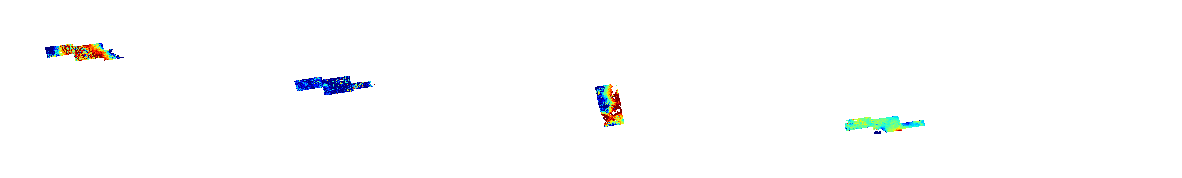

In [138]:
fig, axes = plt.subplots(1,len(mat_list)-1,figsize=(15,10),sharey=True)
for i in range(len(mat_list)-1):
    ax = axes[i];
    mat_diff = mat_list[i+1] - mat_list[i];
    ax.imshow(mat_diff,cmap='jet',vmin=-0.01,vmax=0.01,interpolation='nearest')
    ax.set_axis_off()

In [30]:
len(mat_list)

6

In [140]:
mat_combined= np.zeros([len(mat_list),np.shape(mat_list[0])[0],np.shape(mat_list[0])[1]]);
for i in range(len(mat_list)):
    mat_combined[i,:,:] = mat_list[i];
merged_matrix = np.nanmedian(mat_combined,axis=0)

C:\Users\bvarugu\AppData\Local\Temp\ipykernel_34500\855928705.py:4: RuntimeWarning: All-NaN slice encountered
  merged_matrix = np.nanmedian(mat_combined,axis=0)


C:\Users\bvarugu\AppData\Local\Temp\ipykernel_34500\3562460962.py:1: RuntimeWarning: All-NaN slice encountered
  merged_matrix = np.nanmedian(mat_combined,axis=0)


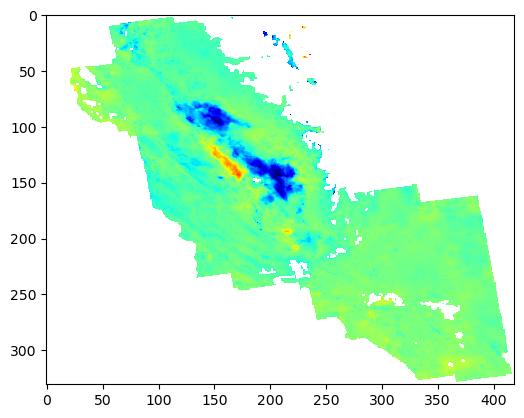

In [144]:
plt.imshow(merged_matrix,cmap='jet',vmin=-0.1,vmax=0.1)

In [146]:
atr = dict()
for key, value in atr1.items():
    atr[key] = value
atr['WIDTH'] = width
atr['LENGTH'] = length
atr['X_FIRST'] = W
atr['Y_FIRST'] = N
print(f'update LENGTH/WIDTH: {length}/{width}')
print(f'update Y/X_FIRST: {N}/{W}')

# update REF_Y/X
coord = ut.coordinate(atr)
ref_y, ref_x = coord.geo2radar(float(atr['REF_LAT']), float(atr['REF_LON']))[:2]
atr['REF_Y'], atr['REF_X'] = ref_y, ref_x
print(f'update REF_Y/X: {ref_y}/{ref_x}')

# delete SUBSET_Y/XMIN/MAX
for key in ['SUBSET_XMIN', 'SUBSET_XMAX', 'SUBSET_YMIN', 'SUBSET_YMAX']:
    if key in atr.keys():
        atr.pop(key)
        print(f'remove {key}')

update LENGTH/WIDTH: 331/419
update Y/X_FIRST: 38.564151241/-122.87915277232129
update REF_Y/X: 99/216


In [148]:
out_file = r'C:\Users\bvarugu\Documents\Asc_velocity_merged_GNSS_integrated.h5'
dsDict = {};
dsDict['velocity'] = merged_matrix
writefile.write(dsDict, out_file=out_file, metadata=atr)

delete exsited file: C:\Users\bvarugu\Documents\Asc_velocity_merged_GNSS_integrated.h5
create HDF5 file: C:\Users\bvarugu\Documents\Asc_velocity_merged_GNSS_integrated.h5 with w mode
create dataset /velocity of float64    in size of (331, 419)           with compression=None
finished writing to C:\Users\bvarugu\Documents\Asc_velocity_merged_GNSS_integrated.h5


'C:\\Users\\bvarugu\\Documents\\Asc_velocity_merged_GNSS_integrated.h5'

In [14]:
0.01666666/0.0005000693047152889

33.32870032782566